In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn Pipelines 1

Goal(s):
- Principal Component Analysis (PCA) as dimensionality reduction technique.
- Scikit-learn pipelines

The iris dataset is a very well-known dataset used in many lectures/examples.\
It consists of 3 different types of irises’ (Setosa, Versicolour, and Virginica) petal and sepal length, stored in a 150x4 numpy array.\
The rowsare the 150 iris samples, the columns are the values measured for the sepal length, sepal width, petal length and petal width.

## 1. Import and explore the dataset

### 1.1 Quick exploration

In [2]:
iris = sns.load_dataset('iris')

Alternative: input via scikit-learn

    from sklearn import datasets
    iris, target = datasets.load_iris(return_X_y=True, as_frame=True)

This imports the dataset as a pandas dataframe (iris) and a pandas series (target).\
'iris' contains the characteristics of the flower, and 'target' their classification (0, 1, or 2)

In [3]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
iris.species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

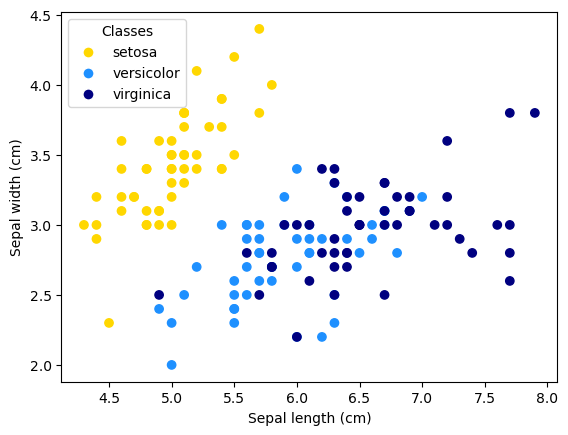

In [5]:
def plot_original_data(iris):

    from matplotlib.lines import Line2D
    colors = {'setosa':'gold', 'versicolor':'dodgerblue', 'virginica':'navy'}

    fig, ax = plt.subplots()
    scat = ax.scatter(iris.sepal_length, iris.sepal_width, c=iris.species.map(colors))
    ax.set(xlabel='Sepal length (cm)', ylabel='Sepal width (cm)')
    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
    legend = ax.legend(handles = handles, loc='upper left', title='Classes') 

plot_original_data(iris)

The plot showsthat it is easy to classify the first class ('Setosa') based on 'Sepal length' and 'Sepal width'. However, in these coordinates, 'versicolor' and 'virginica' overlap and cannot be separated.

### 1.2 PCA decomposition

In [6]:
# TBD INCLUDE HERE SOME MATH DESCRIPTION OF PCA TBD # 

We apply a Principal Component Analysis (PCA) to the iris dataset.
Then we plot the irises across the first 3 PCA dimensions.

In [7]:
# Apply a label encoder to transform the 'species' feature into a numerical feature

# initialize the label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# fit_transform the data
iris_enc = iris.copy()
iris_enc['species'] = le.fit_transform(iris_enc['species'])

# check the outcome
iris_enc.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [8]:
# Apply the PCA analysis to the iris dataset
from sklearn.decomposition import PCA
X_reduced = PCA(n_components=3).fit_transform(iris_enc)

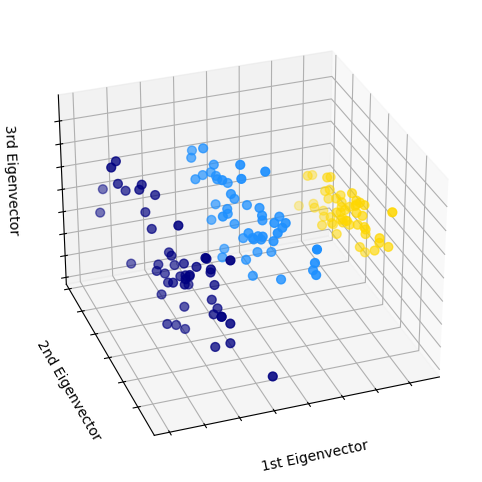

In [9]:
def plot_PCA_data(X_reduced, iris):

    colors = {'setosa':'gold', 'versicolor':'dodgerblue', 'virginica':'navy'}
    
    fig = plt.figure(1, figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

    ax.scatter(X_reduced[:, 0],
               X_reduced[:, 1],
               X_reduced[:, 2],
               c=iris.species.map(colors),
               s=40,
               )

    #ax.set_title("First three PCA dimensions")
    ax.set_xlabel("1st Eigenvector")
    ax.xaxis.set_ticklabels([])
    ax.set_ylabel("2nd Eigenvector")
    ax.yaxis.set_ticklabels([])
    ax.set_zlabel("3rd Eigenvector")
    ax.zaxis.set_ticklabels([])

    plt.show()

plot_PCA_data(X_reduced, iris)

PCA creates 3 new features that are a linear combination of the 4 original features.
In this new set of coordinates, it has become possibel to differentiate between the three types of irises.

## 2. Create a pipeline

### 2.1 Generalities

A typical ML workflow is as follows:

1. split data into training/testing sets.
2. each of them goes through data cleaning/preprocessing.
3. they are then used as input for a ML model.

To avoid repetitive coding (first dealing with the training set, then with the testing set), it is possible to write a scikit-learn **pipeline**.\
A pipeline links every step of the data analysis, where  the output of a given step is used as the input for the next step.

Additional advantages:
- Less prone to (copy/paste) mistakes.
- Workflow easier to understand.
- Less prone to data leakage

### 2.2 Pipeline creation using Pipeline()

The syntax of a pipeline is as follows:\
Pipeline(steps = [(‘step name’, transform function), …])

In [10]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
# PCA already imported
from sklearn.linear_model import LogisticRegression

pipeline_lr = Pipeline([
                    ('Scaler', StandardScaler()),
                    ('PCA', PCA(n_components=3)),
                    ('lr_classifier', LogisticRegression(random_state=0))
                   ])

It is possible to display the pipeline.\
Clicking on the image provides the details of each step. 

In [11]:
from sklearn import set_config

set_config(display='diagram')
display(pipeline_lr)

Pipeline(steps=[('Scaler', StandardScaler()), ('PCA', PCA(n_components=3)),
                ('lr_classifier', LogisticRegression(random_state=0))])

### 2.2 Pipeline creation using make_pipeline()

In [12]:
from sklearn.pipeline import make_pipeline
alt_pipeline = make_pipeline(StandardScaler(), PCA(n_components=3), LogisticRegression(random_state=0))
display(alt_pipeline)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=3)),
                ('logisticregression', LogisticRegression(random_state=0))])

### 2.3 Running/evaluating the pipeline

In [13]:
# TBD TRAIN/TEST SPLIT

In [14]:
# TBD fit transform

In [15]:
# TBD evaluate

### 2.4 Creating other pipelines

In [17]:
# StandardScaler already imported
# PCA already imported
from sklearn.tree import DecisionTreeClassifier

pipeline_dt = Pipeline([
                    ('Scaler', StandardScaler()),
                    ('PCA', PCA(n_components=3)),
                    ('dt_classifier', DecisionTreeClassifier(random_state=0))
                   ])
display(pipeline_dt)

Pipeline(steps=[('Scaler', StandardScaler()), ('PCA', PCA(n_components=3)),
                ('dt_classifier', DecisionTreeClassifier(random_state=0))])

In [18]:
# StandardScaler already imported
# PCA already imported
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = Pipeline([
                    ('Scaler', StandardScaler()),
                    ('PCA', PCA(n_components=3)),
                    ('rf_classifier', RandomForestClassifier(random_state=0))
                   ])
display(pipeline_rf)

Pipeline(steps=[('Scaler', StandardScaler()), ('PCA', PCA(n_components=3)),
                ('rf_classifier', RandomForestClassifier(random_state=0))])

In [19]:
stop

NameError: name 'stop' is not defined